In [1]:
pip install tensorflow

     |████████████████████▏           | 302.8MB 109.1MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████▎   | 423.4MB 115.6MB/s eta 0:00:01

     |████████████████████████████▋   | 429.2MB 115.6MB/s eta 0:00:01

     |█████████████████████████████   | 435.1MB 115.6MB/s eta 0:00:01

     |█████████████████████████████▍  | 441.0MB 115.6MB/s eta 0:00:01

     |█████████████████████████████▉  | 446.9MB 115.6MB/s eta 0:00:01

     |██████████████████████████████▏ | 452.7MB 82.5MB/s eta 0:00:01

     |██████████████████████████████▋ | 458.6MB 82.5MB/s eta 0:00:01

     |███████████████████████████████ | 464.4MB 82.5MB/s eta 0:00:01

     |███████████████████████████████▍| 469.8MB 82.5MB/s eta 0:00:01

     |███████████████████████████████▊| 475.7MB 82.5MB/s eta 0:00:01

     |████████████████████████████████| 479.6MB 82.5MB/s 


     |████████████████████████████████| 2.4MB 79.5MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 81.4MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 87.6MB/s eta 0:00:01
     |████████████████████████████████| 829kB 79.5MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 77.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 82.7MB/s eta 0:00:01
     |████████████████████████████████| 143kB 91.0MB/s eta 0:00:01
     |████████████████████████████████| 5.3MB 82.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 74.5MB/s eta 0:00:01
     |████████████████████████████████| 24.5MB 83.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 83.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 84.3MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 78.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 81.6MB/s eta 0:00:01
     |████████████████████████████████| 450kB 89.8MB/s eta 0:00:

     |████████████████████████████████| 184kB 90.3MB/s eta 0:00:01
     |████████████████████████████████| 122kB 89.4MB/s eta 0:00:01
     |████████████████████████████████| 163kB 92.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 91.2MB/s eta 0:00:01
     |████████████████████████████████| 143kB 86.0MB/s eta 0:00:01
     |████████████████████████████████| 92kB 90.0MB/s eta 0:00:01
     |████████████████████████████████| 153kB 91.3MB/s eta 0:00:01
ERROR: sqlalchemy 2.0.28 has requirement typing-extensions>=4.6.0, but you'll have typing-extensions 4.5.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement importlib-metadata!=4.7.0,<7,>=3.7.0, but you'll have importlib-metadata 7.1.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement packaging<24, but you'll have packaging 24.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: snowflake-snowpark-python 1.0.0 has requirement cloudpic

In [2]:
pip install sklearn

    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-4zs0i6i5/sklearn/setup.py'"'"'; __file__='"'"'/tmp/pip-install-4zs0i6i5/sklearn/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-4zs0i6i5/sklearn/pip-egg-info
         cwd: /tmp/pip-install-4zs0i6i5/sklearn/
    Complete output (15 lines):
    The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
    rather than 'sklearn' for pip commands.
    
    Here is how to fix this error in the main use cases:
    - use 'pip install scikit-learn' rather than 'pip install sklearn'
    - replace 'sklearn' by 'scikit-learn' in your pip requirements files
      (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
    - if the 'sklearn' package is used by one of your dep

In [3]:
pip install seaborn

     |████████████████████████████████| 296kB 6.0MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 82.9MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 78.9MB/s eta 0:00:01
     |████████████████████████████████| 9.2MB 50.8MB/s eta 0:00:01
     |████████████████████████████████| 235kB 88.0MB/s eta 0:00:01
     |████████████████████████████████| 512kB 86.5MB/s eta 0:00:01
     |████████████████████████████████| 348kB 90.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 83.1MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 83.5MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 83.9MB/s eta 0:00:01
     |████████████████████████████████| 307kB 89.6MB/s eta 0:00:01
     |████████████████████████████████| 4.7MB 83.4MB/s eta 0:00:01
     |████████████████████████████████| 112kB 85.3MB/s eta 0:00:01
ERROR: refractio 2.1.5.4 has requirement pandas==2.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: mlflow 2.6.0 h

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install refractml

     |████████████████████████████████| 51kB 4.9MB/s eta 0:00:011
     |████████████████████████████████| 706kB 22.7MB/s eta 0:00:01
     |████████████████████████████████| 143kB 78.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 68.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 80.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 71.4MB/s eta 0:00:01
     |████████████████████████████████| 9.8MB 79.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 84.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 85.6MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 81.6MB/s eta 0:00:01
     |████████████████████████████████| 34.5MB 82.3MB/s eta 0:00:01
     |████████████████████████████████| 71kB 84.7MB/s eta 0:00:01
     |████████████████████████████████| 163kB 86.4MB/s eta 0:00:01
     |████████████████████████████████| 143kB 91.5MB/s eta 0:00:01
Failed to build shutils
ERROR: mlflow 2.6.0 has requirement pytz<2

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15


Uninstalling urllib3-2.2.1:
  Successfully uninstalled urllib3-2.2.1
     |████████████████████████████████| 143kB 7.4MB/s eta 0:00:01
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement cloudpickle==1.6.0, but you'll have cloudpickle 2.2.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement PyYAML==6.0, but you'll have pyyaml 6.0.1 which is incompatible.
ERROR: mosaic-ai-client 1.0.0 has requirement matplotlib==3.1.1, but you'll have matplotlib 3.7.5 which is incompatible.
ERROR: jupyterlab-server 2.25.4 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import time
import seaborn as sns
from snowflake.snowpark.session import Session
import configparser

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

Matplotlib created a temporary cache directory at /tmp/matplotlib-v6n8u424 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


connection successful!


In [2]:
df = session.table("CPG_WAREHOUSE").to_pandas()

In [3]:
df.duplicated().sum()
df.isnull().sum()

DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                        990
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         1
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

In [4]:
df['WORKERS_NUM'] = df['WORKERS_NUM'].fillna(df['WORKERS_NUM'].mean())

In [5]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 'NA']
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != '0']
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 0]

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65394
A+    58674
Name: count, dtype: int64

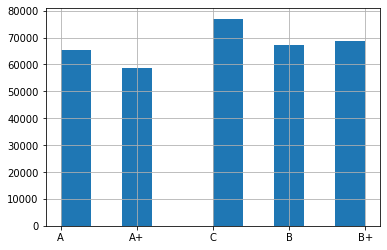

In [6]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

[Text(0.5, 1.0, 'Location Type by zone')]

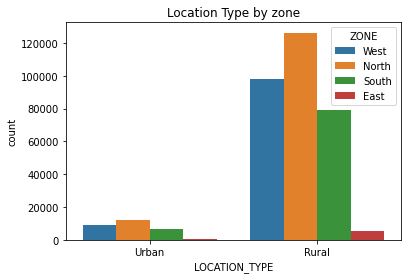

In [7]:
sns.countplot(data=df,x='LOCATION_TYPE',hue='ZONE').set(title='Location Type by zone')

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

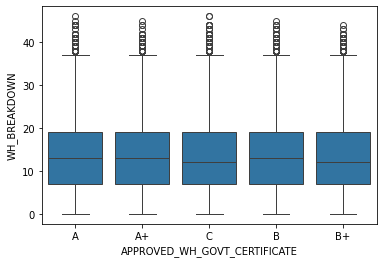

In [8]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [9]:
#label encoder turns label into numeric data
le = LabelEncoder()
df['LOCATION_TYPE']=le.fit_transform(df['LOCATION_TYPE'])
df['WH_CAPACITY_SIZE']=le.fit_transform(df['WH_CAPACITY_SIZE'])
df['APPROVED_WH_GOVT_CERTIFICATE']=le.fit_transform(df['APPROVED_WH_GOVT_CERTIFICATE'])
df['ZONE']=le.fit_transform(df['ZONE'])
df['WH_REGIONAL_ZONE']= le.fit_transform(df['WH_REGIONAL_ZONE'])
df['WAREHOUSE_OWNERSHIP']=le.fit_transform(df['WAREHOUSE_OWNERSHIP'])
## can also use the code below to transform into numeric data by removing "Zone" using lambda expression
##df['WH_regional_zone']=df['WH_regional_zone'].apply(lambda x: x.split(' ')[1]-1)

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

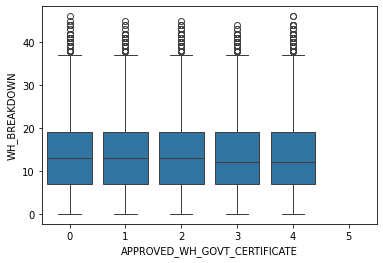

In [10]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [11]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 5]

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

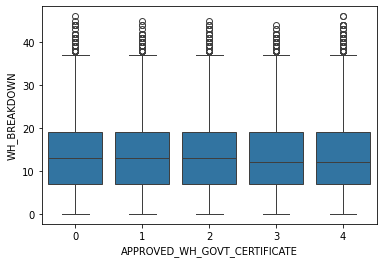

In [12]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [13]:
df = df.drop(['WARE_HOUSE_ID','WH_MANAGER_ID','WH_EST_YEAR','DATE'],axis=1)

<Axes: >

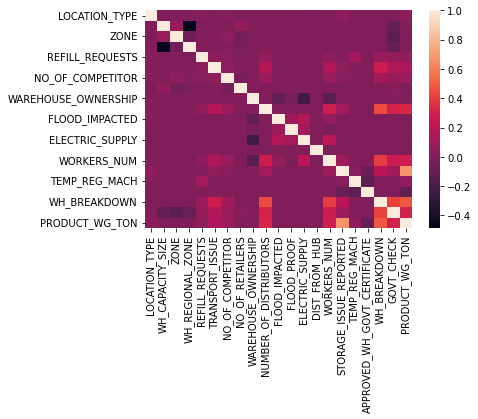

In [14]:
sns.heatmap(df.corr())

In [15]:
#separate the class feature from the rest of the dataset
X = df.drop('APPROVED_WH_GOVT_CERTIFICATE',axis=1).values
y = df['APPROVED_WH_GOVT_CERTIFICATE'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
scaler = MinMaxScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [17]:
print('X train shape: ',X_train.shape)
print('X test shape: ',X_test.shape)

X train shape:  (269829, 20)
X test shape:  (67458, 20)


In [18]:
#define a deep learning model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes (grade of govt certificate)
model.add(Dense(5,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [19]:
#fit the model with data
history = model.fit(x=X_train,
          y=y_train, epochs=90,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.5012 - accuracy: 0.3077 - val_loss: 1.4896 - val_accuracy: 0.3194
Epoch 2/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4899 - accuracy: 0.3185 - val_loss: 1.4871 - val_accuracy: 0.3221
Epoch 3/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4867 - accuracy: 0.3220 - val_loss: 1.4829 - val_accuracy: 0.3231
Epoch 4/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4831 - accuracy: 0.3260 - val_loss: 1.4798 - val_accuracy: 0.3293
Epoch 5/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4798 - accuracy: 0.3294 - val_loss: 1.4770 - val_accuracy: 0.3295
Epoch 6/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4778 - accuracy: 0.3310 - val_loss: 1.4758 - val_accuracy: 0.3324
Epoch 7/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4762 - accuracy: 0.3329 - val_loss: 1.4747 - val_ac

8433/8433 [==============================] - 10s 1ms/step - loss: 1.4610 - accuracy: 0.3428 - val_loss: 1.4657 - val_accuracy: 0.3360
Epoch 58/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4611 - accuracy: 0.3420 - val_loss: 1.4653 - val_accuracy: 0.3358
Epoch 59/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4611 - accuracy: 0.3426 - val_loss: 1.4644 - val_accuracy: 0.3351
Epoch 60/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4608 - accuracy: 0.3429 - val_loss: 1.4670 - val_accuracy: 0.3404
Epoch 61/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4607 - accuracy: 0.3433 - val_loss: 1.4636 - val_accuracy: 0.3378
Epoch 62/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4606 - accuracy: 0.3430 - val_loss: 1.4660 - val_accuracy: 0.3367
Epoch 63/90
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4607 - accuracy: 0.3436 - val_loss: 1.4640 - val_accurac

<Axes: >

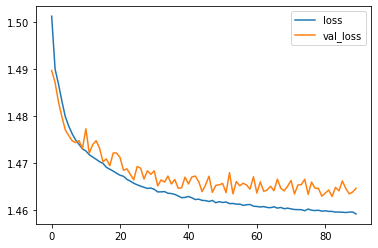

In [20]:
losses = {'loss':history.history['loss'],'val_loss':history.history['val_loss']}
losses = pd.DataFrame(losses)
losses.plot()

In [21]:
#define an earlystopper function
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [22]:
#create another model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))

model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes
model.add(Dense(5,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
#add an early stop as a callback
#this will stop the model fitting  when the validation loss is higher than the training loss after an x amount of epochs (this case 25)
history = model.fit(x=X_train,
          y=y_train, epochs=300,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/300
8433/8433 [==============================] - 11s 1ms/step - loss: 1.5066 - accuracy: 0.3003 - val_loss: 1.4932 - val_accuracy: 0.3105
Epoch 2/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4916 - accuracy: 0.3150 - val_loss: 1.4895 - val_accuracy: 0.3181
Epoch 3/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4881 - accuracy: 0.3191 - val_loss: 1.4852 - val_accuracy: 0.3223
Epoch 4/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4857 - accuracy: 0.3224 - val_loss: 1.4823 - val_accuracy: 0.3260
Epoch 5/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4830 - accuracy: 0.3250 - val_loss: 1.4814 - val_accuracy: 0.3292
Epoch 6/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4808 - accuracy: 0.3273 - val_loss: 1.4778 - val_accuracy: 0.3312
Epoch 7/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4792 - accuracy: 0.3300 - val_loss: 1.4770 -

Epoch 57/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4634 - accuracy: 0.3385 - val_loss: 1.4651 - val_accuracy: 0.3369
Epoch 58/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4633 - accuracy: 0.3382 - val_loss: 1.4661 - val_accuracy: 0.3390
Epoch 59/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4634 - accuracy: 0.3383 - val_loss: 1.4647 - val_accuracy: 0.3386
Epoch 60/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4632 - accuracy: 0.3386 - val_loss: 1.4670 - val_accuracy: 0.3360
Epoch 61/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4632 - accuracy: 0.3392 - val_loss: 1.4656 - val_accuracy: 0.3387
Epoch 62/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4632 - accuracy: 0.3383 - val_loss: 1.4645 - val_accuracy: 0.3368
Epoch 63/300
8433/8433 [==============================] - 10s 1ms/step - loss: 1.4629 - accuracy: 0.3385 - val_loss: 1

In [26]:
import matplotlib.pyplot as plt

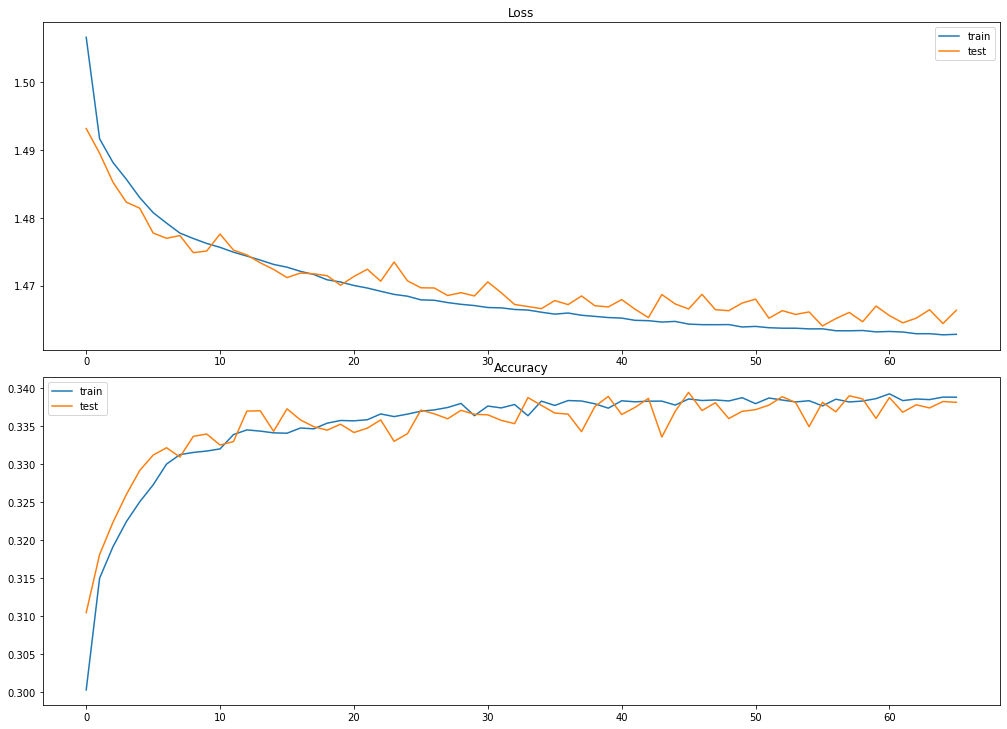

<Figure size 432x288 with 0 Axes>

In [27]:
#plot the loss and validation loss of the model
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.tight_layout()
# plot accuracy and validation accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
plt.tight_layout()

In [28]:
##evaluate the model and print out the accuracy and loss
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)

print('Train Accuracy: %.2f, Test Accuracy: %.2f' % (trainAcc*100, testAcc*100))
print('Train Loss: %.2f, Test Loss: %.2f' % (trainLoss*100, testLoss*100))


Train Accuracy: 34.02, Test Accuracy: 33.81
Train Loss: 146.21, Test Loss: 146.64


In [29]:
#make predictions --> currently a probability
yProbs = model.predict(X_test)

#turn the yprobs into class labels using argmax to round the value to whole num
yPreds = yProbs.argmax(axis=1)

2109/2109 [==============================] - 1s 647us/step


In [30]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_curve,roc_auc_score,recall_score,roc_auc_score


              precision    recall  f1-score   support

           0       0.28      0.40      0.33     13008
           1       0.46      0.71      0.56     11724
           2       0.28      0.01      0.02     13554
           3       0.29      0.32      0.31     13749
           4       0.32      0.31      0.31     15423

    accuracy                           0.34     67458
   macro avg       0.33      0.35      0.31     67458
weighted avg       0.32      0.34      0.30     67458



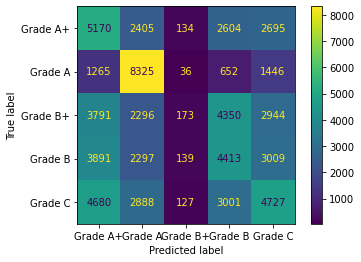

In [31]:
#print out a classification report
print(classification_report(y_test,yPreds))

conMat = confusion_matrix(y_test,yPreds)

#make a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conMat,display_labels=['Grade A+','Grade A','Grade B+','Grade B','Grade C'])
disp.plot()

              precision    recall  f1-score   support

           0       0.28      0.40      0.33     13008
           1       0.46      0.71      0.56     11724
           2       0.28      0.01      0.02     13554
           3       0.29      0.32      0.31     13749
           4       0.32      0.31      0.31     15423

    accuracy                           0.34     67458
   macro avg       0.33      0.35      0.31     67458
weighted avg       0.32      0.34      0.30     67458

2109/2109 [==============================] - 1s 675us/step
ROC AUC:  0.6636045740029612


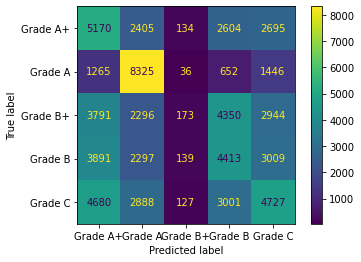

In [32]:
#print out a classification report
print(classification_report(y_test,yPreds))

#print ROC AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')
print('ROC AUC: ', roc_auc)

conMat = confusion_matrix(y_test,yPreds)

#make a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conMat,display_labels=['Grade A+','Grade A','Grade B+','Grade B','Grade C'])
disp.plot()

2109/2109 [==============================] - 1s 676us/step


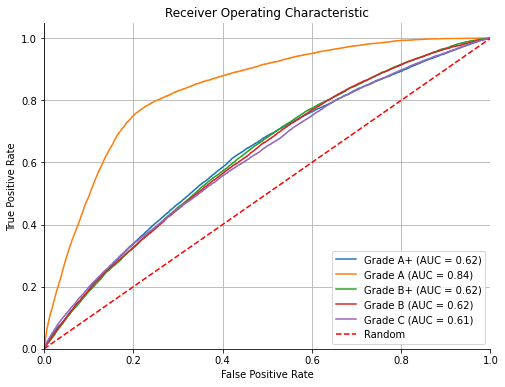

In [33]:
#plot roc curve of the model
y_test = pd.get_dummies(y_test)

class_probabilities = model.predict(X_test)
plt.figure(figsize=(8, 6))
rank = ['dummy','A+','A','B+','B','C']
for i in range(1, class_probabilities.shape[1]+1):
    fpr, tpr, _ = roc_curve(y_test.values[:, i-1], class_probabilities[:, i-1])
    roc_auc = roc_auc_score(y_test.values[:, i-1], class_probabilities[:, i-1])
    plt.plot(fpr, tpr, label='Grade {} (AUC = {:.2f})'.format(rank[i], roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
sns.despine()
plt.show()

In [29]:
pip show urllib3

Name: urllib3
Version: 2.2.1
Summary: HTTP library with thread-safe connection pooling, file post, and more.
Home-page: None
Author: None
Author-email: Andrey Petrov <andrey.petrov@shazow.net>
License: None
Location: /tmp/pip_packages
Requires: 
Required-by: requests, docker, databricks-cli, refractml, snowflake-connector-python
Note: you may need to restart the kernel to use updated packages.


In [30]:
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

Uninstalling urllib3-2.2.1:
  Successfully uninstalled urllib3-2.2.1
     |████████████████████████████████| 143kB 1.5MB/s eta 0:00:01
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement cloudpickle==1.6.0, but you'll have cloudpickle 2.2.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement PyYAML==6.0, but you'll have pyyaml 6.0.1 which is incompatible.
ERROR: mosaic-ai-client 1.0.0 has requirement matplotlib==3.1.1, but you'll have matplotlib 3.7.5 which is incompatible.
ERROR: jupyterlab-server 2.25.4 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
pip install refractml

     |████████████████████████████████| 51kB 4.9MB/s eta 0:00:011
     |████████████████████████████████| 706kB 20.6MB/s eta 0:00:01
     |████████████████████████████████| 143kB 85.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 69.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 76.6MB/s eta 0:00:01
     |████████████████████████████████| 51kB 78.9MB/s eta 0:00:01
     |████████████████████████████████| 9.8MB 85.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 85.1MB/s eta 0:00:01
     |████████████████████████████████| 34.5MB 81.1MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 82.3MB/s eta 0:00:01
     |████████████████████████████████| 307kB 86.3MB/s eta 0:00:01
     |████████████████████████████████| 163kB 90.2MB/s eta 0:00:01
     |████████████████████████████████| 143kB 90.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 90.0MB/s eta 0:00:01
Failed to build shutils
ERROR: mlflow 2.6.0 has requirement pytz<2

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
from refractml import *

ImportError: cannot import name 'appengine' from 'urllib3.contrib' (/tmp/pip_packages/urllib3/contrib/__init__.py)

In [39]:
from refractml.constants import MLModelFlavours
import requests

In [50]:
df.columns.tolist()

['LOCATION_TYPE',
 'WH_CAPACITY_SIZE',
 'ZONE',
 'WH_REGIONAL_ZONE',
 'REFILL_REQUESTS',
 'TRANSPORT_ISSUE',
 'NO_OF_COMPETITOR',
 'NO_OF_RETAILERS',
 'WAREHOUSE_OWNERSHIP',
 'NUMBER_OF_DISTRIBUTORS',
 'FLOOD_IMPACTED',
 'FLOOD_PROOF',
 'ELECTRIC_SUPPLY',
 'DIST_FROM_HUB',
 'WORKERS_NUM',
 'STORAGE_ISSUE_REPORTED',
 'TEMP_REG_MACH',
 'APPROVED_WH_GOVT_CERTIFICATE',
 'WH_BREAKDOWN',
 'GOVT_CHECK',
 'PRODUCT_WG_TON']

In [51]:
testing_data= pd.DataFrame(data= X_test,columns = ['LOCATION_TYPE',
 'WH_CAPACITY_SIZE',
 'ZONE',
 'WH_REGIONAL_ZONE',
 'REFILL_REQUESTS',
 'TRANSPORT_ISSUE',
 'NO_OF_COMPETITOR',
 'NO_OF_RETAILERS',
 'WAREHOUSE_OWNERSHIP',
 'NUMBER_OF_DISTRIBUTORS',
 'FLOOD_IMPACTED',
 'FLOOD_PROOF',
 'ELECTRIC_SUPPLY',
 'DIST_FROM_HUB',
 'WORKERS_NUM',
 'STORAGE_ISSUE_REPORTED',
 'TEMP_REG_MACH',
 'WH_BREAKDOWN',
 'GOVT_CHECK',
 'PRODUCT_WG_TON'])

In [52]:
testing_data

,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,NO_OF_RETAILERS,WAREHOUSE_OWNERSHIP,NUMBER_OF_DISTRIBUTORS,FLOOD_IMPACTED,FLOOD_PROOF,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,0.0,0.0,0.333333,1.0,0.12,0.000000,0.181818,0.376176,1.0,0.086957,0.0,0.0,0.0,0.587963,0.303753,0.408451,1.0,0.130435,0.319444,0.411950
1,0.0,0.0,0.333333,0.8,0.00,0.000000,0.090909,0.172148,0.0,0.449275,0.0,0.0,1.0,0.291667,0.330645,0.169014,1.0,0.152174,0.319444,0.213850
2,0.0,0.0,0.333333,1.0,0.20,0.000000,0.090909,0.495529,1.0,0.275362,0.0,0.0,1.0,0.078704,0.387097,0.338028,0.0,0.413043,0.388889,0.410531
3,0.0,1.0,0.666667,1.0,0.36,0.000000,0.045455,0.311484,0.0,0.376812,0.0,0.0,1.0,0.087963,0.282258,0.239437,0.0,0.086957,0.208333,0.227292
4,0.0,0.5,0.666667,0.2,0.24,0.090909,0.045455,0.365135,0.0,0.369565,1.0,0.0,1.0,0.800926,0.250000,0.295775,0.0,0.195652,0.291667,0.352080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67453,0.0,1.0,0.666667,1.0,0.00,0.000000,0.090909,0.666278,0.0,0.253623,0.0,0.0,1.0,0.657407,0.266129,0.309859,0.0,0.173913,0.083333,0.257298
67454,0.0,0.5,0.333333,0.6,0.08,0.045455,0.090909,0.441956,1.0,0.427536,0.0,0.0,0.0,0.064815,0.419355,0.323944,0.0,0.304348,0.541667,0.274864
67455,0.0,1.0,0.333333,0.0,0.04,0.136364,0.272727,0.404945,1.0,0.086957,0.0,0.0,1.0,0.351852,0.306452,0.183099,0.0,0.021739,0.402778,0.264437
67456,0.0,1.0,0.333333,1.0,0.28,0.090909,0.227273,0.166239,0.0,0.673913,0.0,0.0,1.0,0.236111,0.580645,0.154930,1.0,0.543478,0.833333,0.405031


In [53]:
payload = str(testing_data.iloc[158].to_dict())
req = requests.Request()
req.json= {'payload': payload}
print({'payload': payload})

{'payload': "{'LOCATION_TYPE': 0.0, 'WH_CAPACITY_SIZE': 0.0, 'ZONE': 0.3333333333333333, 'WH_REGIONAL_ZONE': 1.0, 'REFILL_REQUESTS': 0.24, 'TRANSPORT_ISSUE': 0.09090909090909091, 'NO_OF_COMPETITOR': 0.09090909090909091, 'NO_OF_RETAILERS': 0.3958479122929787, 'WAREHOUSE_OWNERSHIP': 0.0, 'NUMBER_OF_DISTRIBUTORS': 0.6304347826086957, 'FLOOD_IMPACTED': 0.0, 'FLOOD_PROOF': 0.0, 'ELECTRIC_SUPPLY': 1.0, 'DIST_FROM_HUB': 0.7546296296296298, 'WORKERS_NUM': 0.3225806451612903, 'STORAGE_ISSUE_REPORTED': 0.35211267605633806, 'TEMP_REG_MACH': 1.0, 'WH_BREAKDOWN': 0.3695652173913043, 'GOVT_CHECK': 0.5555555555555556, 'PRODUCT_WG_TON': 0.49260839914644605}"}


In [54]:
@scoring_func
def score(model, request):
    import json
    payload = request.json["payload"]
    if isinstance(request.json["payload"],str):
        payload_data = eval(payload)
        if isinstance(payload_data['WAREHOUSE_OWNERSHIP'], float):
            data_json = eval(payload)
            data = pd.DataFrame([data_json])
            prediction = pd.DataFrame(model.predict(data))
            return prediction[0].to_list()[0]
        elif isinstance(payload_data['WAREHOUSE_OWNERSHIP'], dict):
            data = pd.DataFrame(eval(payload))
            prediction = pd.DataFrame(model.predict(data))
            return prediction[0].tolist()
        elif isinstance(payload_data['WAREHOUSE_OWNERSHIP'], list):
            data = pd.DataFrame(payload_data)
            prediction = model.predict(data)
            return prediction.tolist()
    return "This method is not allowed"

In [63]:
training_data= pd.DataFrame(data= X_train,columns = ['LOCATION_TYPE',
 'WH_CAPACITY_SIZE',
 'ZONE',
 'WH_REGIONAL_ZONE',
 'REFILL_REQUESTS',
 'TRANSPORT_ISSUE',
 'NO_OF_COMPETITOR',
 'NO_OF_RETAILERS',
 'WAREHOUSE_OWNERSHIP',
 'NUMBER_OF_DISTRIBUTORS',
 'FLOOD_IMPACTED',
 'FLOOD_PROOF',
 'ELECTRIC_SUPPLY',
 'DIST_FROM_HUB',
 'WORKERS_NUM',
 'STORAGE_ISSUE_REPORTED',
 'TEMP_REG_MACH',
 'WH_BREAKDOWN',
 'GOVT_CHECK',
 'PRODUCT_WG_TON'])

In [56]:
print(score(model, req))

1/1 [==============================] - 0s 76ms/step
0.1338416188955307


In [60]:
testing_data

,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,NO_OF_RETAILERS,WAREHOUSE_OWNERSHIP,NUMBER_OF_DISTRIBUTORS,FLOOD_IMPACTED,FLOOD_PROOF,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,0.0,0.0,0.333333,1.0,0.12,0.000000,0.181818,0.376176,1.0,0.086957,0.0,0.0,0.0,0.587963,0.303753,0.408451,1.0,0.130435,0.319444,0.411950
1,0.0,0.0,0.333333,0.8,0.00,0.000000,0.090909,0.172148,0.0,0.449275,0.0,0.0,1.0,0.291667,0.330645,0.169014,1.0,0.152174,0.319444,0.213850
2,0.0,0.0,0.333333,1.0,0.20,0.000000,0.090909,0.495529,1.0,0.275362,0.0,0.0,1.0,0.078704,0.387097,0.338028,0.0,0.413043,0.388889,0.410531
3,0.0,1.0,0.666667,1.0,0.36,0.000000,0.045455,0.311484,0.0,0.376812,0.0,0.0,1.0,0.087963,0.282258,0.239437,0.0,0.086957,0.208333,0.227292
4,0.0,0.5,0.666667,0.2,0.24,0.090909,0.045455,0.365135,0.0,0.369565,1.0,0.0,1.0,0.800926,0.250000,0.295775,0.0,0.195652,0.291667,0.352080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67453,0.0,1.0,0.666667,1.0,0.00,0.000000,0.090909,0.666278,0.0,0.253623,0.0,0.0,1.0,0.657407,0.266129,0.309859,0.0,0.173913,0.083333,0.257298
67454,0.0,0.5,0.333333,0.6,0.08,0.045455,0.090909,0.441956,1.0,0.427536,0.0,0.0,0.0,0.064815,0.419355,0.323944,0.0,0.304348,0.541667,0.274864
67455,0.0,1.0,0.333333,0.0,0.04,0.136364,0.272727,0.404945,1.0,0.086957,0.0,0.0,1.0,0.351852,0.306452,0.183099,0.0,0.021739,0.402778,0.264437
67456,0.0,1.0,0.333333,1.0,0.28,0.090909,0.227273,0.166239,0.0,0.673913,0.0,0.0,1.0,0.236111,0.580645,0.154930,1.0,0.543478,0.833333,0.405031


In [69]:
register_model(model, 
               score, 
               name="CPG_Inventory_Model", 
               description="Warehouse Certificate Allocation",
               flavour=MLModelFlavours.tensorflow,
               model_type="regression",
               y_true=y_test,
               features=testing_data.columns,
               input_type="json", 
               explain_ai=True,
               x_train=training_data, 
               x_test=testing_data, 
               y_train=y_train.tolist(),
               y_test=y_test.tolist(),
               y_pred=yProbs,
               feature_names=testing_data.columns.tolist(),
               original_features=testing_data.columns.tolist(),
               feature_ids=testing_data.columns,
               kyd=True,
               kyd_score = True)

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


In [65]:
y_test

,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,NO_OF_RETAILERS,WAREHOUSE_OWNERSHIP,NUMBER_OF_DISTRIBUTORS,FLOOD_IMPACTED,FLOOD_PROOF,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
